In [ ]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

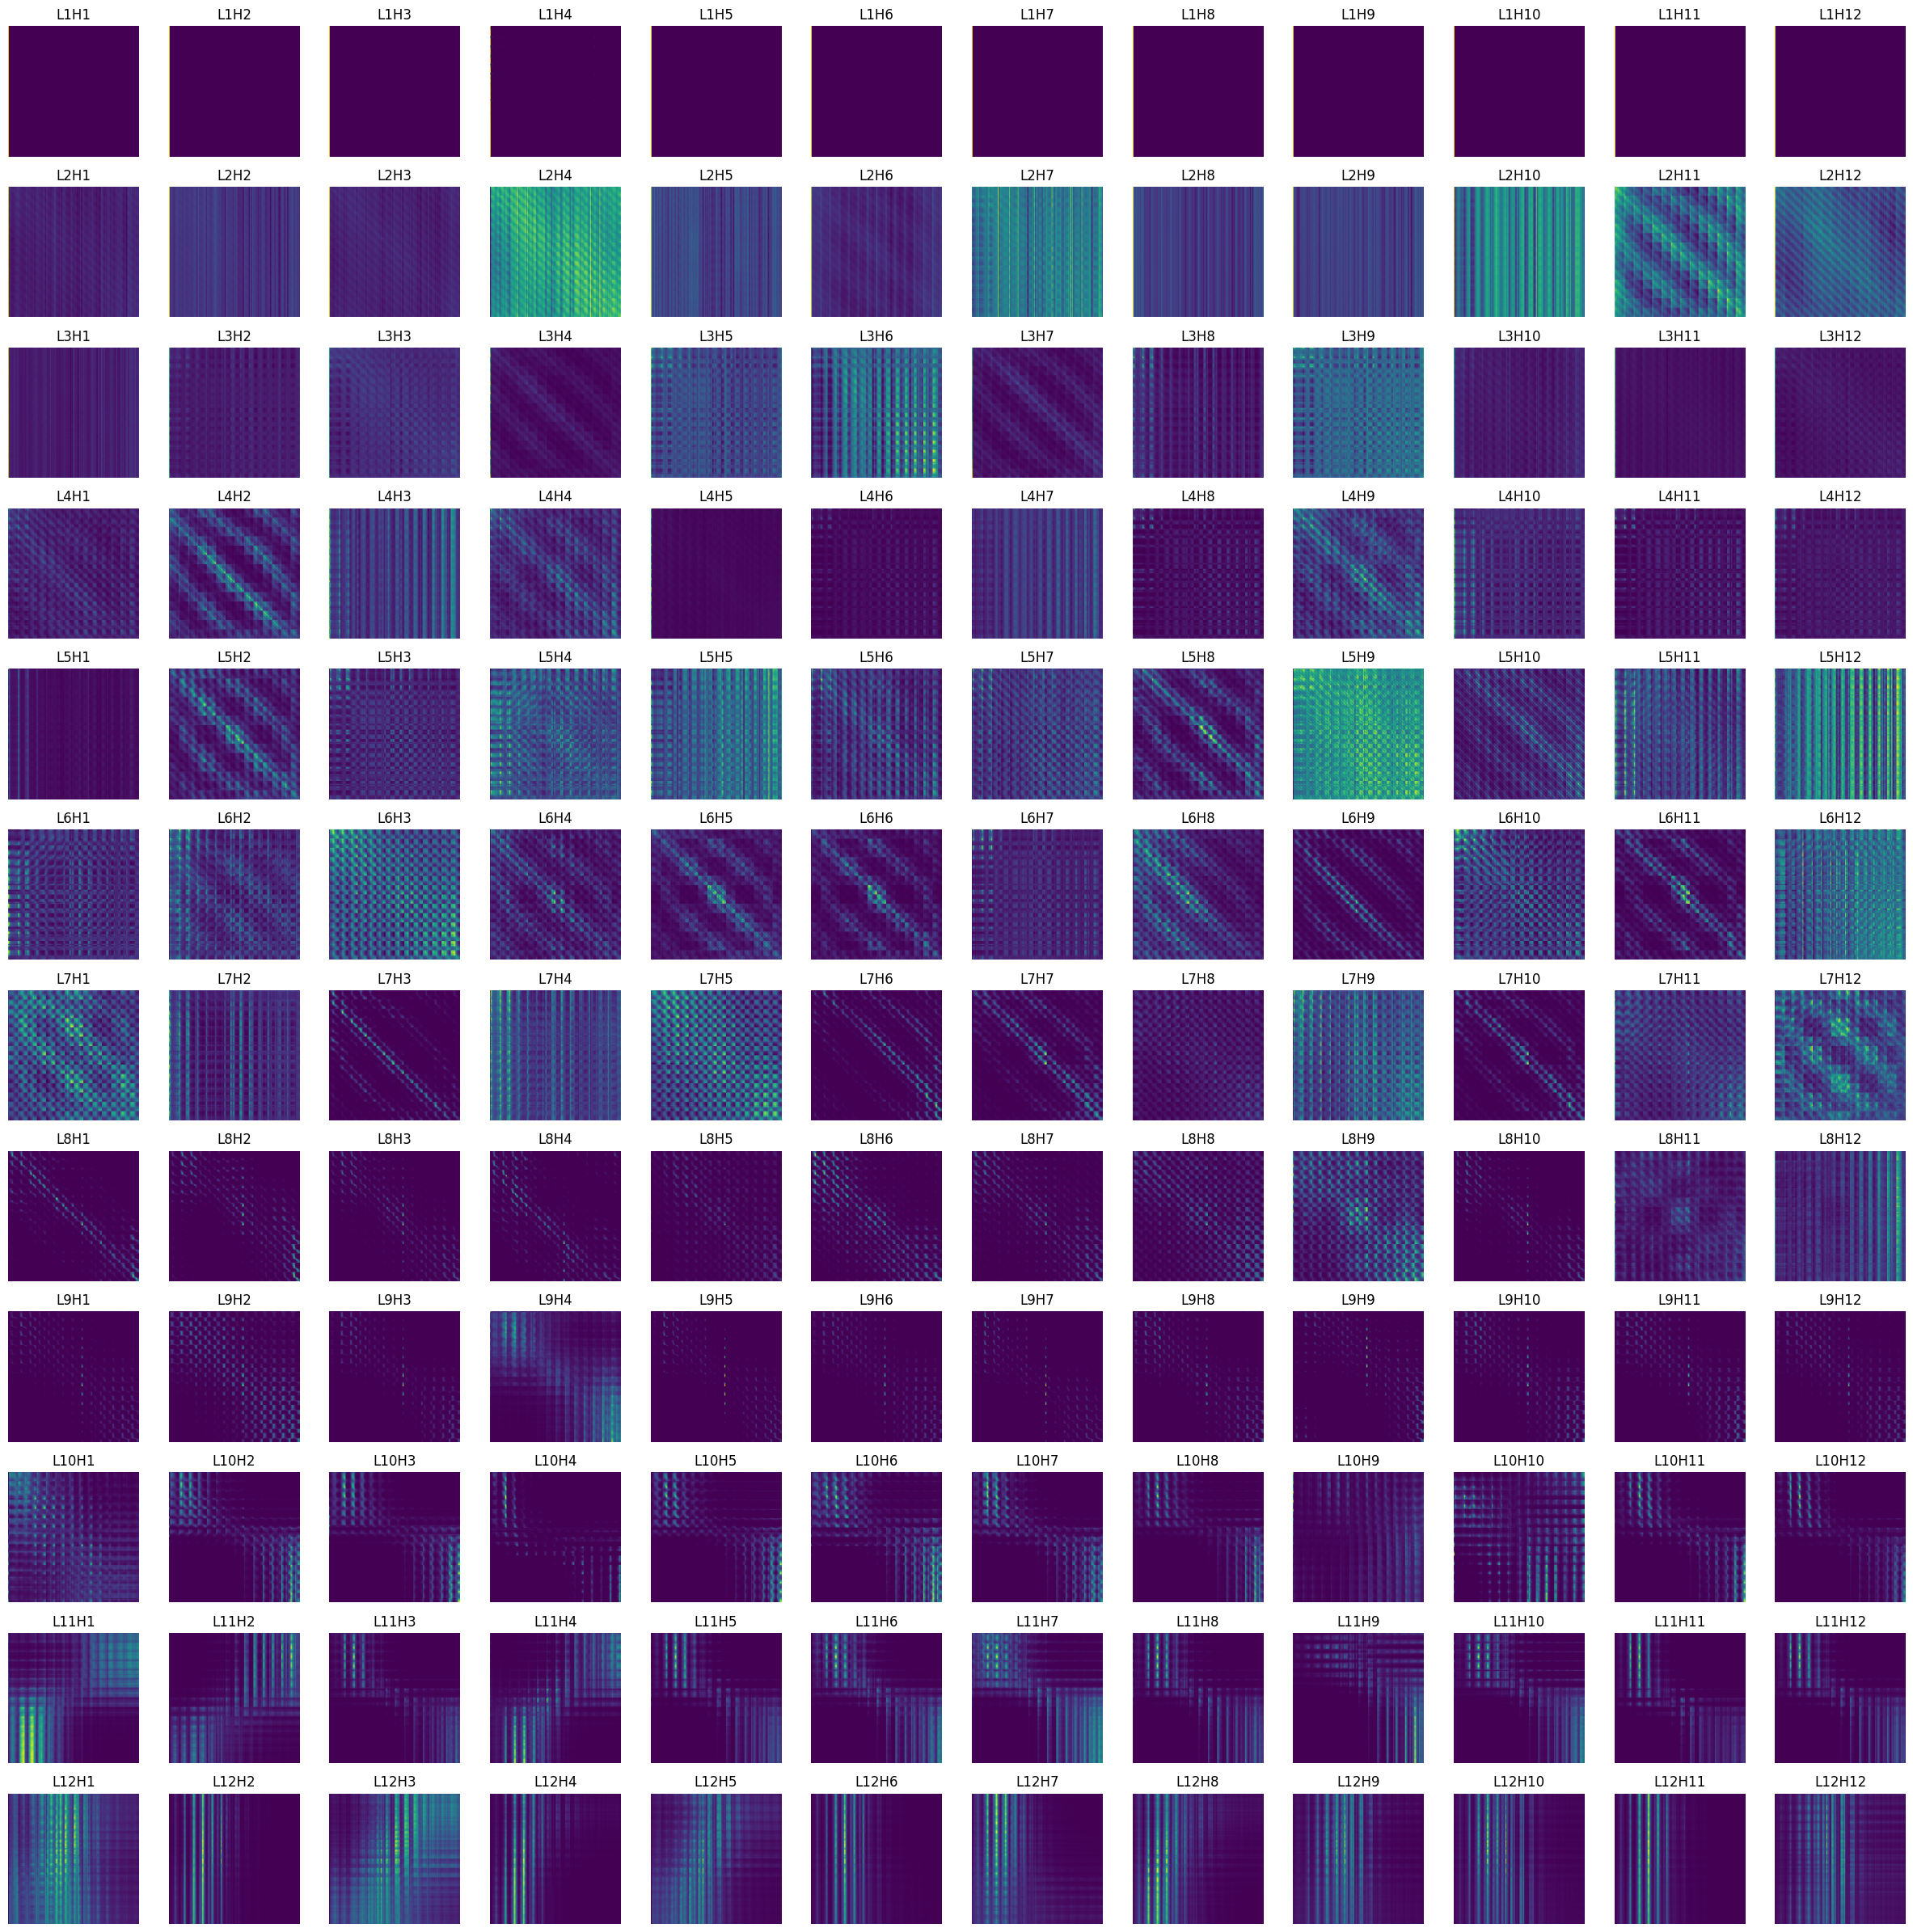

In [ ]:
import torch
import torch.nn as nn
import timm
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# Hooked attention maps
attention_maps = []

# Safely override the forward function of transformer blocks
for blk in model.blocks:
    # Provide default drop_path if it doesn't exist
    if not hasattr(blk, 'drop_path'):
        blk.drop_path = nn.Identity()

    def new_forward(self, x):
        B, N, C = x.shape

        qkv = self.attn.qkv(x).reshape(B, N, 3, self.attn.num_heads, C // self.attn.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) * self.attn.scale
        attn_weights = attn_scores.softmax(dim=-1)  # (B, num_heads, N, N)
        self.attn_weights = attn_weights  # Store for external use

        attn_output = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        attn_output = self.attn.proj(attn_output)

        x = x + self.drop_path(attn_output)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return self.norm1(x)

    # Inject our forward method into each block
    blk.forward = new_forward.__get__(blk, type(blk))

# Load and preprocess image
image = Image.open("luna2.jpg").convert("RGB")
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
input_tensor = transform(image).unsqueeze(0)

# Forward pass
with torch.no_grad():
    model(input_tensor)

# Extract stored attention maps
attn_maps_np = [blk.attn_weights.squeeze(0).cpu().numpy() for blk in model.blocks]

# Visualize attention maps
def visualize_attention(attn_maps_np):
    num_layers = len(attn_maps_np)
    num_heads = attn_maps_np[0].shape[0]

    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 2, num_layers * 2))

    for i in range(num_layers):
        for j in range(num_heads):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            attn_map = attn_maps_np[i][j]  # shape: [num_tokens, num_tokens]
            ax.imshow(attn_map, cmap='viridis')
            ax.set_title(f"L{i+1}H{j+1}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_attention(attn_maps_np)


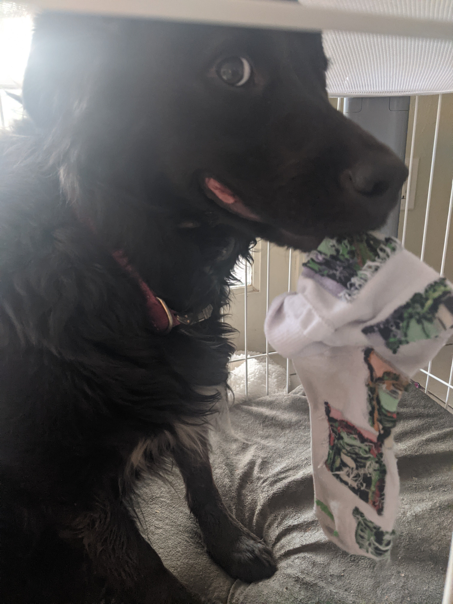

In [ ]:
from PIL import Image
from IPython.display import display
display(image.resize(( int(image.width * 0.15), int(image.height * 0.15))))

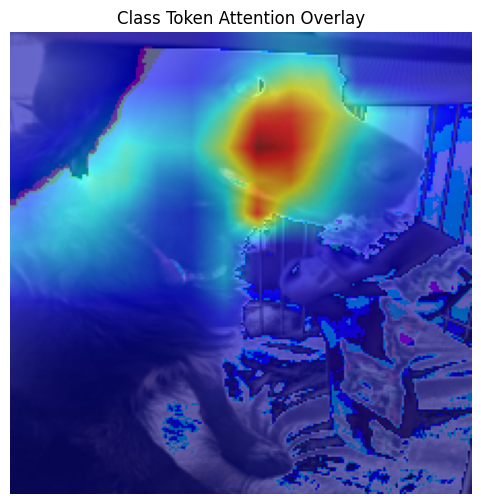

In [ ]:
import numpy as np
import cv2
from torchvision.transforms.functional import to_pil_image

def show_attention_overlay(image_tensor, attn_map, patch_size=16, alpha=0.6):
    """
    Overlay attention map on top of the input image.
    """
    image = to_pil_image(image_tensor.squeeze(0).cpu()).convert("RGB")
    image_np = np.array(image)

    # Use only the class token's attention to other tokens (shape: [num_tokens])
    # In ViT, first token (index 0) is class token, so take its attention
    cls_attn = attn_map[:, 0, 1:]  # Exclude the class token itself

    # Assume square grid of patches
    num_patches = cls_attn.shape[-1]
    grid_size = int(np.sqrt(num_patches))
    cls_attn_map = cls_attn.reshape(grid_size, grid_size)

    # Normalize attention map
    cls_attn_map -= cls_attn_map.min()
    cls_attn_map /= cls_attn_map.max()

    # Resize attention map to image resolution
    cls_attn_map_resized = cv2.resize(cls_attn_map, (image_np.shape[1], image_np.shape[0]))
    cls_attn_map_color = cv2.applyColorMap(np.uint8(255 * cls_attn_map_resized), cv2.COLORMAP_JET)
    cls_attn_map_color = cv2.cvtColor(cls_attn_map_color, cv2.COLOR_BGR2RGB)

    # Overlay attention on original image
    overlay = (1 - alpha) * image_np + alpha * cls_attn_map_color
    overlay = overlay.astype(np.uint8)

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Class Token Attention Overlay")
    plt.show()



# Apply this to the final layer attention map
last_layer_attn = attn_maps_np[-1]  # [num_heads, num_tokens, num_tokens]
avg_attn = np.mean(last_layer_attn, axis=0, keepdims=True)  # [1, num_tokens, num_tokens]

# Show attention overlay
show_attention_overlay(input_tensor, avg_attn)


# Lab steps

From the following list, chose at least 4 points (marked in parenthesis) and implement the suggested improvements. Note that you can also select and implement your own improvements to the lab. The goal is for you to gain some practical experience dealing with vision transformers and attention mechanisms.

---

### 1. **Compare Attention Across Layers** (1 pt)

Observe how attention patterns evolve from early to deeper layers

- Modify the visualization code to extract and visualize attention maps from **multiple layers**, and overlay them over the analysis image..
- Plot them side-by-side for comparison.
- Describe how attention focuses shift from broad/global in early layers to fine/local in deeper ones.


---

### 2. **Compare Attention Across Heads** (1 pt)

See how different heads focus on different regions.

- Instead of averaging attention across all heads, visualize each head separately.
- Identify if some heads focus on textures, edges, or object parts.

---

### 3. **Compare ViT vs CNN Attention** (2 pts)

Contrast global vs local focus.

- Run a CNN (e.g., ResNet) with Grad-CAM on the same image.
- Compare the attention overlay to the ViT visualization.


---

### 4. **Visualize Attention for Misclassified Images** (1 pt)

Diagnose model behavior.

- Feed images the model misclassifies.
- Visualize where it looked via class token attention.
- Figure out why the model failed.


---

### 5. **Use Different Patch Sizes** (1 pt)

Investigate effect of patch resolution.

- Change the model (e.g., `vit_base_patch32_224`) to use a larger patch size.
- Re-run visualizations and compare granularity.


---

### 6. **Visualize Attention Rollout** (3 pts)

Understand cumulative attention across layers.

- Implement **attention rollout** (recursive multiplication of attention matrices).
- Visualize the result for each token’s final impact on the class token.

**Resources**: [Abnar & Zuidema 2020](https://arxiv.org/abs/2005.00928)


---

### 7. **Finetune ViT on Custom Dataset and Visualize Attention**  (2 pts)

Apply ViT to a new task and study adaptation.

- Use a small dataset like CIFAR-10 or Oxford Pets.
- Finetune a ViT model and compare attention before/after finetuning.
- Hypothesize what changes and why.


---

### 8. **Propose and implement your own** (points vary)

Propose your own extension in a way that can potentially help you deepen your understanding of ViTs and/or help you with the final project. Talk to me to decide on the number of points